# Proyecto Final Econometría II


**Por;**

Santiago Sánchez

José Angel Tovar

**Objetivo**

Pronosticar en la medida de lo posible los resultados de los siguietes equipos por jornada.

**Motivación**

El futbol es un deporte sumamente dificil de predecir, esto porque interfieren una serie de variables incontrolables en muchas de las ocasiones, es por esto, que nosotros como aficionados nos emociona y motiva el tratar de crear un modelo que pronostique resultados concretos mas aun de equipos de una liga tan competitiva como lo es la Premier League.

**Modelo general**

*Y(p:gane/pierda) = a + B1(local/visitante) + B2(Goal por partido) + B3(Posición) + B4(Posición contrincante) + Error*

**3 modelos a evaluar**

Y = P(Liverpool_gane_la_siguiente_jornada: Si/No)

Y = P(Chelsea_gane_la_siguiente_jornada: Si/No)

Y = P(Tottenham_gane_la_siguiente_jornada: Si/No)

**Data set**

29 datos para cada variable x

In [1]:
import urllib
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import statistics as stats
from scipy import stats
from sklearn import linear_model
from sklearn import model_selection 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
resultados_home = 'http://www.resultados-futbol.com/premier/grupo1/jornada{}'
headers = {'User-agent': 'Safari/13.1'}

In [2]:
equipos_info = {}
for page in range(1, 30):
    equipos_info[page] = {}
    url = resultados_home.format(page)
    html = requests.get(url, headers=headers)
    soup = BeautifulSoup(html.content, "lxml")
    table_2 = soup.find("table", {"id" : "tabla2"})
    tds = table_2.findAll("td")
    for i, td in enumerate(tds):
        try:
            clase = td['class'][0]
            if clase == 'equipo':
                equipo = td.get_text().strip()
                equipos_info[page][equipo] = []
                for ii in range(1, 30):
                    value = int(tds[i + ii].get_text())
                    equipos_info[page][equipo].append(value)
        except:
            pass
    print(page, end=' | ')

1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 | 24 | 25 | 26 | 27 | 28 | 29 | 

In [3]:
def create_dataframe_for_team(equipos_info, team):
    lista_jornadas = []
    lista_ptos = []
    lista_ganados = []
    lista_goles_favor = []
    lista_goles_contra = []
    lista_y = []
    for jornada, jornada_info in equipos_info.items():        
        equipo_info = jornada_info[team]
        ptos = equipo_info[0]
        ganados = equipo_info[2]
        goles_favor = equipo_info[5]
        goles_contra = equipo_info[6]        
        lista_jornadas.append(jornada)
        lista_ptos.append(ptos)
        lista_ganados.append(ganados)
        lista_goles_favor.append(goles_favor)
        lista_goles_contra.append(goles_contra)
    
    df = pd.DataFrame({'jornada': lista_jornadas,
                       'ptos': lista_ptos,
                       'ganados': lista_ganados,
                       'goles_favor': lista_goles_favor,
                       'goles_contra': lista_goles_contra})
    
    for i in range(len(df)):
        try:
            if df['ganados'][i] == df['ganados'][i-1]:
                lista_y.append(0) 
            else:
                lista_y.append(1)
        except:
            lista_y.append(np.nan)
    df['y'] = lista_y
    df = df.dropna()
    df = df.reset_index(drop=True)
    df['y'] = df['y'].astype(int)
    return df

In [4]:
chelsea_df = create_dataframe_for_team(equipos_info, 'Chelsea')
liverpool_df = create_dataframe_for_team(equipos_info, 'Liverpool')
man_city_df = create_dataframe_for_team(equipos_info, 'Man. City')
tottenham_df = create_dataframe_for_team(equipos_info, 'Tottenham')

In [5]:
liverpool_df_final=pd.read_excel(r"/Users/josetovar/Desktop/Python docs/proyecto final econometría/liverpool.xlsx")
chelsea_df_final=pd.read_excel(r"/Users/josetovar/Desktop/Python docs/proyecto final econometría/chelsea.xlsx")
tottenham_df_final=pd.read_excel(r"/Users/josetovar/Desktop/Python docs/proyecto final econometría/tottenham.xlsx")

In [6]:
def sigmoide_G(x):
    rv = 1 / (1 + np.exp(-x)) 
    return rv

# Liverpool

In [7]:
liverpool_df_final

,jornada,y,goles_for,goles_against,dif_goles,c_v,pos,posc
0,2,1,2,1,1,0,3,17
1,3,1,3,1,2,1,1,2
2,4,1,3,0,3,0,1,6
3,5,1,3,1,2,1,1,14
4,6,1,2,1,1,0,1,6
5,7,1,1,0,1,0,1,10
6,8,1,2,1,1,1,1,3
7,9,0,1,1,0,0,1,12
8,10,1,2,1,1,1,1,7
9,11,1,2,1,1,0,1,15


# Estadísticas descriptivas 

In [8]:
liverpool_df_final.describe()

,jornada,y,goles_for,goles_against,dif_goles,c_v,pos,posc
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,15.500000,0.928571,2.214286,0.714286,1.500000,0.500000,1.071429,10.714286
std,8.225975,0.262265,1.066567,0.762896,1.319371,0.509175,0.377964,5.949523
min,2.000000,0.000000,0.000000,0.000000,-3.000000,0.000000,1.000000,2.000000
25%,8.750000,1.000000,2.000000,0.000000,1.000000,0.000000,1.000000,6.000000
50%,15.500000,1.000000,2.000000,1.000000,1.000000,0.500000,1.000000,11.000000
75%,22.250000,1.000000,3.000000,1.000000,2.000000,1.000000,1.000000,15.500000
max,29.000000,1.000000,5.000000,3.000000,4.000000,1.000000,3.000000,20.000000


In [9]:
liverpool_df_final.var()

jornada          67.666667
y                 0.068783
goles_for         1.137566
goles_against     0.582011
dif_goles         1.740741
c_v               0.259259
pos               0.142857
posc             35.396825
dtype: float64

In [10]:
liverpool_df_final.corr()

,jornada,y,goles_for,goles_against,dif_goles,c_v,pos,posc
jornada,1.000000,-0.103005,-0.139307,0.023607,-0.126265,0.106112,-0.321634,0.284547
y,-0.103005,1.000000,0.453963,-0.475997,0.642214,0.277350,0.053376,-0.227190
goles_for,-0.139307,0.453963,1.000000,-0.013005,0.815911,0.340997,-0.039375,-0.153421
goles_against,0.023607,-0.475997,-0.013005,1.000000,-0.588740,0.095346,0.073398,0.315907
dif_goles,-0.126265,0.642214,0.815911,-0.588740,1.000000,0.220527,-0.074271,-0.306691
c_v,0.106112,0.277350,0.340997,0.095346,0.220527,1.000000,-0.192450,-0.122261
pos,-0.321634,0.053376,-0.039375,0.073398,-0.074271,-0.192450,1.000000,0.207056
posc,0.284547,-0.227190,-0.153421,0.315907,-0.306691,-0.122261,0.207056,1.000000


# Gráficos

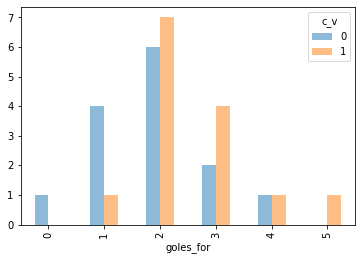

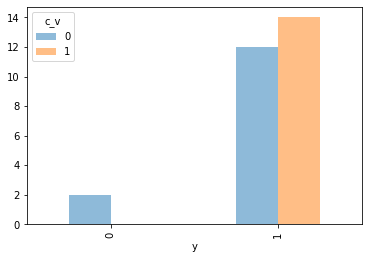

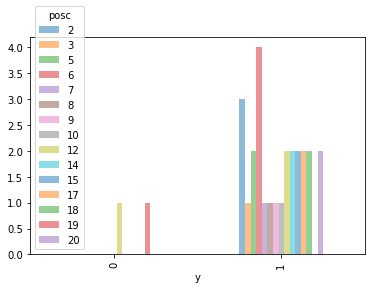

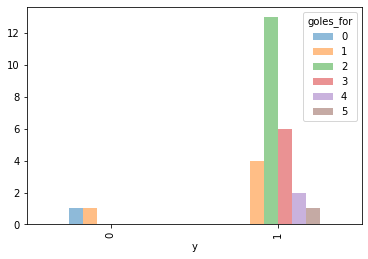

In [11]:
pd.crosstab(liverpool_df_final.goles_for,liverpool_df_final.c_v).plot(kind = 'bar', alpha =0.5)
# Liverpool solo tuvo diferencia de goles negativa cuando jugó de visita 
pd.crosstab(liverpool_df_final.y,liverpool_df_final.c_v).plot(kind = 'bar', alpha =0.5)
# Liverpool nunca perdió en casa 
pd.crosstab(liverpool_df_final.y,liverpool_df_final.posc).plot(kind = 'bar', alpha =0.5)
pd.crosstab(liverpool_df_final.y,liverpool_df_final.goles_for).plot(kind = 'bar', alpha =0.5)

# Modelo Logit

In [12]:
x_liv= liverpool_df_final[['pos','c_v','posc','goles_for']]
y_liv= liverpool_df_final[['y']]
x_liv= sm.add_constant(x_liv)
modelliv= sm.Logit(y_liv, x_liv).fit()
print(modelliv.summary())

         Current function value: 0.080334
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   28
Model:                          Logit   Df Residuals:                       23
Method:                           MLE   Df Model:                            4
Date:                Sun, 24 May 2020   Pseudo R-squ.:                  0.6878
Time:                        13:57:32   Log-Likelihood:                -2.2493
converged:                      False   LL-Null:                       -7.2049
Covariance Type:            nonrobust   LLR p-value:                   0.04195
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -22.6666   1.07e+05     -0.000      1.000   -2.09e+05    2.09e+05
pos           -2.1419   1.07e+05  -2.01e-05      1.000   -2.09e+0

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


# Validación Liverpool

In [13]:
Y_hat_ps = modelliv.predict(x_liv)
Y_hat_ps

0     1.000000e+00
1     1.000000e+00
2     1.000000e+00
3     1.000000e+00
4     1.000000e+00
5     7.500000e-01
6     1.000000e+00
7     7.500000e-01
8     1.000000e+00
9     1.000000e+00
10    1.000000e+00
11    1.000000e+00
12    1.000000e+00
13    1.000000e+00
14    1.000000e+00
15    1.000000e+00
16    1.000000e+00
17    1.000000e+00
18    1.000000e+00
19    1.000000e+00
20    7.500000e-01
21    1.000000e+00
22    1.000000e+00
23    1.000000e+00
24    7.500000e-01
25    1.000000e+00
26    1.681778e-11
27    1.000000e+00
dtype: float64

In [14]:
suma_correct = 0
suma_y_1 = 0
threshold = .5
for i in range(28):
    true_y = liverpool_df_final["y"][i]
    y_hat_p = Y_hat_ps[i]
    if y_hat_p >= threshold:
        y_hat = 1
    else:
        y_hat = 0
    if true_y == y_hat:
        suma_correct += 1
    suma_y_1 += y_hat
print('Fitness:', suma_correct / 28)
print(liverpool_df_final["y"].sum())
print(suma_y_1)

Fitness: 0.9642857142857143
26
27


In [15]:
suma_correct = 0
suma_y_1 = 0
threshold = liverpool_df_final["y"].sum()/28
for i in range(28):
    y_true=liverpool_df_final["y"][i]
    y_hat_p = Y_hat_ps[i]
    if y_hat_p >= threshold:
        y_hat = 1
    else:
        y_hat = 0
    if y_true == y_hat:
        suma_correct += 1
    suma_y_1 += y_hat
print('Fitness:', suma_correct / 28)
print(liverpool_df_final["y"].sum())
print(suma_y_1)

Fitness: 0.8928571428571429
26
23


In [16]:
success_rates = []
for threshold in np.linspace(0, 1, 100):
    suma_correct = 0
    suma_y_1 = 0
    for i in range(28):
        true_y = liverpool_df_final["y"][i]
        y_hat_p = Y_hat_ps[i]
        if y_hat_p >= threshold:
            y_hat = 1
        else:
            y_hat = 0
        if true_y == y_hat:
            suma_correct += 1
        suma_y_1 += y_hat
    success_rate = suma_y_1 / 28
    success_rates.append(success_rate)

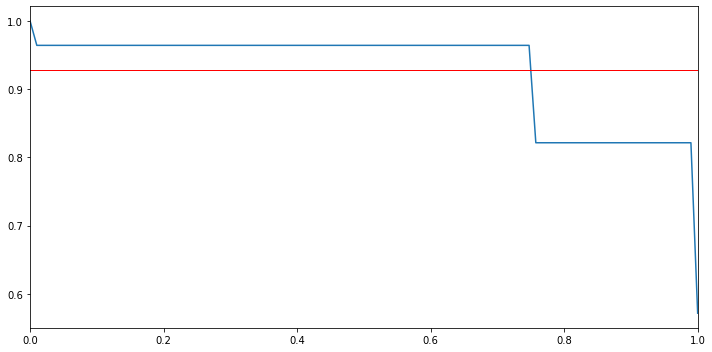


Done!


In [17]:
fig = plt.figure(figsize=(10, 5))
axis = plt.gca()
plt.plot(list(np.linspace(0, 1, 100)), success_rates)
plt.axhline(liverpool_df_final["y"].sum() / 28, color='red', linewidth=1)
plt.xlim(0, 1)
fig.tight_layout()
plt.show()
plt.close(plt.gcf())
print('\nDone!')

# Cambios marginales 

In [18]:
print("PEA",modelliv.get_margeff(at="mean").summary())

PEA         Logit Marginal Effects       
Dep. Variable:                      y
Method:                          dydx
At:                              mean
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pos        -4.753e-18   8.85e-13  -5.37e-06      1.000   -1.74e-12    1.74e-12
c_v         3.659e-17   8.43e-12   4.34e-06      1.000   -1.65e-11    1.65e-11
posc       -2.384e-27   5.02e-19  -4.74e-09      1.000   -9.85e-19    9.85e-19
goles_for   5.749e-17   1.28e-11   4.49e-06      1.000   -2.51e-11    2.51e-11


# PEA: ¿Cómo afecta al Liverpool jugar en casa o de visita?

In [19]:
sigmoide_G(-22.6666 - 2.1419*1.071429 - 1.074e-09*10.714286 + 25.9072*2.214286 + 16.4903*1) - sigmoide_G(-22.6666 - 2.1419*1.071429 - 1.074e-09*10.714286 + 25.9072*2.214286 + 16.4903*0)

8.43769498715119e-15

# PEA: Jugar contra un equipo 2 lugares arriba en casa

In [20]:
sigmoide_G(-22.6666 - 2.1419*1.071429 - 1.074e-09*10.714286 + 25.9072*2.214286 + 16.4903*1)*( -1.074e-09)*(-2)

2.148e-09

# PEA: Jugar contra un equipo 2 lugares arriba de visita

In [21]:
sigmoide_G(-22.6666 - 2.1419*1.071429 - 1.074e-09*10.714286 + 25.9072*2.214286 + 16.4903*0)*( -1.074e-09)*(-2)

2.147999999999982e-09

# PEA: Contar con un gol a favor

In [22]:
sigmoide_G(-22.6666 - 2.1419*1.071429 - 1.074e-09*10.714286 + 25.9072*2.214286 + 16.4903*1)*(25.9072)*(1)

25.9072

# Chelsea

In [23]:
chelsea_df_final

,jornada,y,goles_for,goles_against,dif_goles,c_v,pos,posc
0,2,0,1,1,0,1,19,12
1,3,1,3,2,1,0,15,11
2,4,0,2,2,0,1,14,9
3,5,1,5,2,3,0,11,17
4,6,0,1,2,-1,1,6,1
5,7,1,2,0,2,1,11,15
6,8,1,4,1,3,0,7,14
7,9,1,1,0,1,1,5,16
8,10,1,4,2,2,0,4,8
9,11,1,2,1,1,0,4,20


# Estdísticas descriptivas

In [24]:
chelsea_df_final.describe()

,jornada,y,goles_for,goles_against,dif_goles,c_v,pos,posc
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,15.500000,0.500000,1.821429,1.250000,0.571429,0.535714,5.964286,11.714286
std,8.225975,0.509175,1.334821,0.844371,1.642685,0.507875,4.086855,5.017430
min,2.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,3.000000,1.000000
25%,8.750000,0.000000,1.000000,1.000000,-1.000000,0.000000,4.000000,8.750000
50%,15.500000,0.500000,2.000000,1.000000,0.500000,1.000000,4.000000,12.500000
75%,22.250000,1.000000,2.000000,2.000000,2.000000,1.000000,5.250000,15.250000
max,29.000000,1.000000,5.000000,3.000000,4.000000,1.000000,19.000000,20.000000


In [25]:
chelsea_df_final.var()

jornada          67.666667
y                 0.259259
goles_for         1.781746
goles_against     0.712963
dif_goles         2.698413
c_v               0.257937
pos              16.702381
posc             25.174603
dtype: float64

In [26]:
chelsea_df_final.corr()

,jornada,y,goles_for,goles_against,dif_goles,c_v,pos,posc
jornada,1.000000,-0.185695,-0.180459,-0.055989,-0.117859,0.004433,-0.697921,-0.105889
y,-0.185695,1.000000,0.681171,-0.559950,0.841334,-0.071611,0.026698,0.115979
goles_for,-0.180459,0.681171,1.000000,-0.090368,0.859035,-0.290727,0.209256,-0.007900
goles_against,-0.055989,-0.559950,-0.090368,1.000000,-0.587450,-0.323875,0.077813,-0.122391
dif_goles,-0.117859,0.841334,0.859035,-0.587450,1.000000,-0.069762,0.130041,0.056492
c_v,0.004433,-0.071611,-0.290727,-0.323875,-0.069762,1.000000,0.098779,-0.024916
pos,-0.697921,0.026698,0.209256,0.077813,0.130041,0.098779,1.000000,0.048251
posc,-0.105889,0.115979,-0.007900,-0.122391,0.056492,-0.024916,0.048251,1.000000


# Gráficos

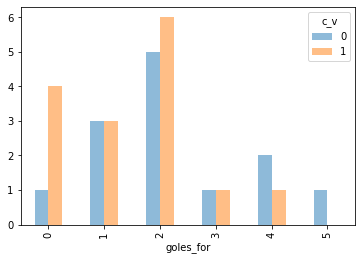

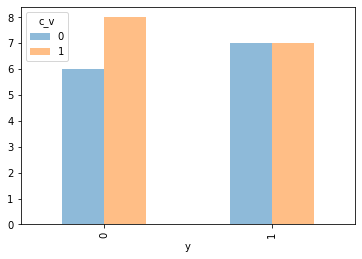

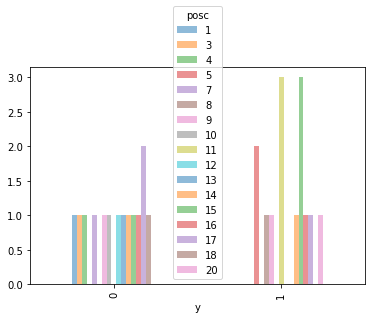

In [27]:
pd.crosstab(chelsea_df_final.goles_for,chelsea_df_final.c_v).plot(kind = 'bar', alpha =0.5)
# 0, 1 son los más frecuentes 
pd.crosstab(chelsea_df_final.y,chelsea_df_final.c_v).plot(kind = 'bar', alpha =0.5)
# Chelsea perdió mas veces en casa
pd.crosstab(chelsea_df_final.y,chelsea_df_final.posc).plot(kind = 'bar', alpha =0.5)
# Ganó 3 veces a la posición 11 y 15

# Modelo Logit

In [28]:
x_chelsea= chelsea_df_final[['pos','c_v','posc','goles_for']]
y_chelsea= chelsea_df_final[['y']]
x_chelsea= sm.add_constant(x_chelsea)
model_chelsea = sm.Logit(y_chelsea, x_chelsea).fit()
print(model_chelsea.summary())

Optimization terminated successfully.
         Current function value: 0.303812
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   28
Model:                          Logit   Df Residuals:                       23
Method:                           MLE   Df Model:                            4
Date:                Sun, 24 May 2020   Pseudo R-squ.:                  0.5617
Time:                        13:57:33   Log-Likelihood:                -8.5067
converged:                       True   LL-Null:                       -19.408
Covariance Type:            nonrobust   LLR p-value:                 0.0002194
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.7981      3.099     -2.194      0.028     -12.872      -0.725
pos           -0.1992      0.

# Validación Chelsea

In [29]:
Y_hat_ps = model_chelsea.predict(x_chelsea)
Y_hat_ps

0     0.016097
1     0.810481
2     0.417482
3     0.999929
4     0.042626
5     0.756040
6     0.998767
7     0.321667
8     0.998387
9     0.849082
10    0.840112
11    0.026568
12    0.026099
13    0.925918
14    0.144504
15    0.019680
16    0.391988
17    0.026099
18    0.605298
19    0.086584
20    0.996804
21    0.003277
22    0.858573
23    0.325675
24    0.006283
25    0.746751
26    0.759459
27    0.999771
dtype: float64

In [30]:
suma_correct = 0
suma_y_1 = 0
threshold = .5
for i in range(28):
    true_y = chelsea_df_final["y"][i]
    y_hat_p = Y_hat_ps[i]
    if y_hat_p >= threshold:
        y_hat = 1
    else:
        y_hat = 0
    if true_y == y_hat:
        suma_correct += 1
    suma_y_1 += y_hat
print('Fitness:', suma_correct / 28)
print(chelsea_df_final["y"].sum())
print(suma_y_1)

Fitness: 0.8571428571428571
14
14


In [31]:
suma_correct = 0
suma_y_1 = 0
threshold = chelsea_df_final["y"].sum()/28
for i in range(28):
    y_true=chelsea_df_final["y"][i]
    y_hat_p = Y_hat_ps[i]
    if y_hat_p >= threshold:
        y_hat = 1
    else:
        y_hat = 0
    if y_true == y_hat:
        suma_correct += 1
    suma_y_1 += y_hat
print('Fitness:', suma_correct / 28)
print(chelsea_df_final["y"].sum())
print(suma_y_1)

Fitness: 0.8571428571428571
14
14


In [32]:
success_rates = []
for threshold in np.linspace(0, 1, 100):
    suma_correct = 0
    suma_y_1 = 0
    for i in range(28):
        true_y = chelsea_df_final["y"][i]
        y_hat_p = Y_hat_ps[i]
        if y_hat_p >= threshold:
            y_hat = 1
        else:
            y_hat = 0
        if true_y == y_hat:
            suma_correct += 1
        suma_y_1 += y_hat
    success_rate = suma_y_1 / 28
    success_rates.append(success_rate)

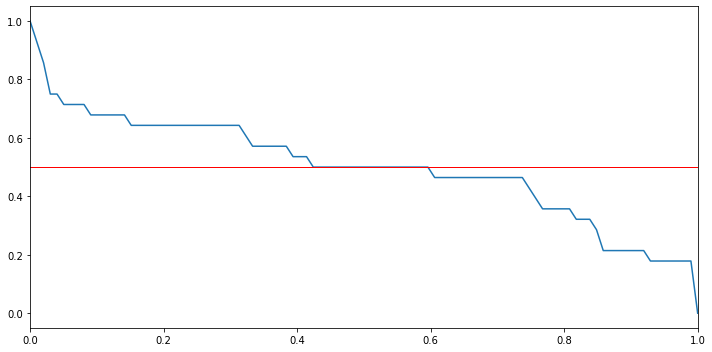


Done!


In [33]:
fig = plt.figure(figsize=(10, 5))
axis = plt.gca()
plt.plot(list(np.linspace(0, 1, 100)), success_rates)
plt.axhline(chelsea_df_final["y"].sum() / 28, color='red', linewidth=1)
plt.xlim(0, 1)
fig.tight_layout()
plt.show()
plt.close(plt.gcf())
print('\nDone!')

# Cambios marginales

In [34]:
print("PEA",model_chelsea.get_margeff(at="mean").summary())

PEA         Logit Marginal Effects       
Dep. Variable:                      y
Method:                          dydx
At:                              mean
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pos           -0.0481      0.043     -1.112      0.266      -0.133       0.037
c_v            0.3667      0.326      1.124      0.261      -0.273       1.006
posc           0.0348      0.030      1.150      0.250      -0.025       0.094
goles_for      0.7760      0.314      2.469      0.014       0.160       1.392


# PEA: ¿Cómo afecta a Chelsea jugar en casa o de visita?

In [35]:
sigmoide_G(-6.7981-0.1992*5.964286+0.1444*11.714286+3.2169*1.821429+1.5203*1) - sigmoide_G(-6.7981-0.1992*5.964286+0.1444*11.714286+3.2169*1.821429+1.5203*0)

0.35457696616609313

# PEA: Probabilidad de ganar si juega con un contrincante 5 posiciones abajo 

In [36]:
sigmoide_G(-6.7981-0.1992*5.964286+0.1444*11.714286+3.2169*1.821429+1.5203*1)*(0.1444)*(5)

0.5396526186669921

# PEA: Probabilidad de ganar si juega con un contrincante 3 posiciones arriba

In [37]:
sigmoide_G(-6.7981-0.1992*5.964286+0.1444*11.714286+3.2169*1.821429+1.5203*1)*(-0.1992)*(1)

-0.1488903069784831

# Tottenham 

In [38]:
tottenham_df_final

,jornada,y,goles_favor,goles_contra,dif_goles,c_v,pos,posc
0,2,0,2,2,0,0,6,1
1,3,0,0,1,-1,1,6,18
2,4,0,2,2,0,0,7,3
3,5,1,4,0,4,1,9,4
4,6,0,1,2,-1,0,3,5
5,7,1,2,1,1,1,7,13
6,8,0,0,3,-3,0,6,16
7,9,0,1,1,0,1,9,20
8,10,0,1,2,-1,0,7,1
9,11,0,1,1,0,0,11,16


# Estadísticas descriptivas

In [39]:
tottenham_df_final.describe()

,jornada,y,goles_favor,goles_contra,dif_goles,c_v,pos,posc
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,15.500000,0.357143,1.571429,1.392857,0.178571,0.464286,7.178571,10.250000
std,8.225975,0.487950,1.259882,0.831745,1.634208,0.507875,2.277971,6.507119
min,2.000000,0.000000,0.000000,0.000000,-3.000000,0.000000,3.000000,1.000000
25%,8.750000,0.000000,1.000000,1.000000,-1.000000,0.000000,6.000000,4.000000
50%,15.500000,0.000000,1.500000,1.000000,0.000000,0.000000,7.000000,10.000000
75%,22.250000,1.000000,2.000000,2.000000,1.000000,1.000000,8.000000,16.000000
max,29.000000,1.000000,5.000000,3.000000,5.000000,1.000000,14.000000,20.000000


In [40]:
tottenham_df_final.var()

jornada         67.666667
y                0.238095
goles_favor      1.587302
goles_contra     0.691799
dif_goles        2.670635
c_v              0.257937
pos              5.189153
posc            42.342593
dtype: float64

In [41]:
tottenham_df_final.corr()

,jornada,y,goles_favor,goles_contra,dif_goles,c_v,pos,posc
jornada,1.000000,0.101500,-0.042885,-0.067666,0.001378,0.004433,-0.170969,0.089605
y,0.101500,1.000000,0.740170,-0.358514,0.753098,0.352282,0.307025,0.134144
goles_favor,-0.042885,0.740170,1.000000,-0.186819,0.866026,0.206725,0.324469,-0.004518
goles_contra,-0.067666,-0.358514,-0.186819,1.000000,-0.652985,-0.360105,-0.253423,-0.059878
dif_goles,0.001378,0.753098,0.866026,-0.652985,1.000000,0.342652,0.379129,0.026992
c_v,0.004433,0.352282,0.206725,-0.360105,0.342652,1.000000,0.149777,-0.014009
pos,-0.170969,0.307025,0.324469,-0.253423,0.379129,0.149777,1.000000,0.274223
posc,0.089605,0.134144,-0.004518,-0.059878,0.026992,-0.014009,0.274223,1.000000


# Gráficos 

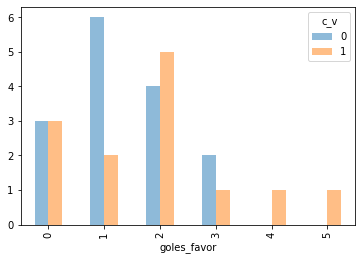

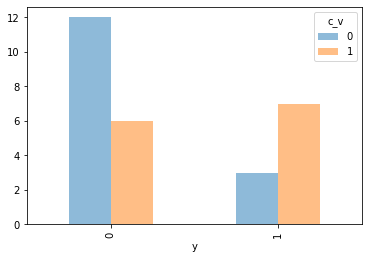

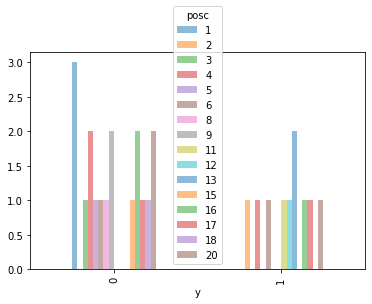

In [42]:
pd.crosstab(tottenham_df_final.goles_favor,tottenham_df_final.c_v).plot(kind = 'bar', alpha =0.5)
# De visita únicamente ganó 3 veces 
pd.crosstab(tottenham_df_final.y,tottenham_df_final.c_v).plot(kind = 'bar', alpha =0.5)
# Perdió o empató 12 veces de visita 
pd.crosstab(tottenham_df_final.y,tottenham_df_final.posc).plot(kind = 'bar', alpha =0.5)


# Modelo Logit

In [43]:
x_tot= tottenham_df_final[['pos','c_v','posc','goles_favor']]
y_tot= tottenham_df_final[['y']]
x_tot= sm.add_constant(x_tot)
totmodel= sm.Logit(y_tot, x_tot).fit()
print(totmodel.summary())

         Current function value: 0.091708
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   28
Model:                          Logit   Df Residuals:                       23
Method:                           MLE   Df Model:                            4
Date:                Sun, 24 May 2020   Pseudo R-squ.:                  0.8593
Time:                        13:57:35   Log-Likelihood:                -2.5678
converged:                      False   LL-Null:                       -18.249
Covariance Type:            nonrobust   LLR p-value:                 2.582e-06
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -333.5469   6.73e+05     -0.000      1.000   -1.32e+06    1.32e+06
pos            16.7331    929.172      0.018      0.986   -180

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


# Validación Tottenham

In [44]:
Y_hat_ps = totmodel.predict(x_tot)
Y_hat_ps

0      1.439254e-07
1      7.689761e-97
2      6.033930e-01
3      1.000000e+00
4      4.013854e-77
5      9.999995e-01
6     6.325075e-104
7      5.146713e-28
8      1.438430e-47
9      2.534232e-20
10     8.843231e-12
11     1.000000e+00
12     1.000000e+00
13     4.485040e-63
14     1.000000e+00
15     3.966072e-01
16    2.087988e-102
17     9.999995e-01
18     7.075678e-10
19    8.366789e-104
20     8.939145e-95
21     1.635874e-89
22     1.000000e+00
23     6.983053e-01
24     1.000000e+00
25     1.816486e-62
26     3.016930e-01
27     1.534418e-48
dtype: float64

In [45]:
suma_correct = 0
suma_y_1 = 0
threshold = .5
for i in range(28):
    true_y = tottenham_df_final["y"][i]
    y_hat_p = Y_hat_ps[i]
    if y_hat_p >= threshold:
        y_hat = 1
    else:
        y_hat = 0
    if true_y == y_hat:
        suma_correct += 1
    suma_y_1 += y_hat
print('Fitness:', suma_correct / 28)
print(tottenham_df_final["y"].sum())
print(suma_y_1)

Fitness: 0.9285714285714286
10
10


In [46]:
suma_correct = 0
suma_y_1 = 0
threshold = tottenham_df_final["y"].sum()/28
for i in range(28):
    y_true=tottenham_df_final["y"][i]
    y_hat_p = Y_hat_ps[i]
    if y_hat_p >= threshold:
        y_hat = 1
    else:
        y_hat = 0
    if y_true == y_hat:
        suma_correct += 1
    suma_y_1 += y_hat
print('Fitness:', suma_correct / 28)
print(tottenham_df_final["y"].sum())
print(suma_y_1)

Fitness: 0.9642857142857143
10
11


In [47]:
success_rates = []
for threshold in np.linspace(0, 1, 100):
    suma_correct = 0
    suma_y_1 = 0
    for i in range(28):
        true_y = tottenham_df_final["y"][i]
        y_hat_p = Y_hat_ps[i]
        if y_hat_p >= threshold:
            y_hat = 1
        else:
            y_hat = 0
        if true_y == y_hat:
            suma_correct += 1
        suma_y_1 += y_hat
    success_rate = suma_y_1 / 28
    success_rates.append(success_rate)

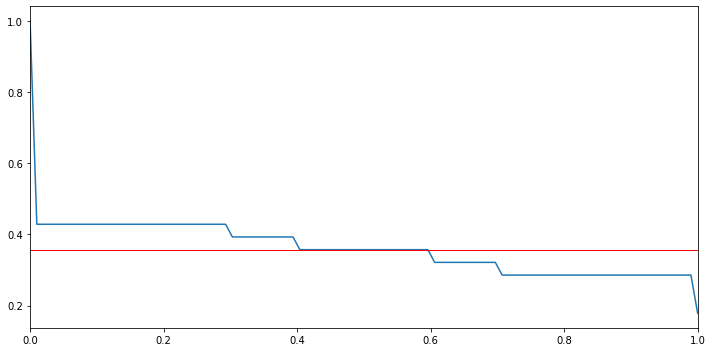


Done!


In [48]:
fig = plt.figure(figsize=(10, 5))
axis = plt.gca()
plt.plot(list(np.linspace(0, 1, 100)), success_rates)
plt.axhline(tottenham_df_final["y"].sum() / 28, color='red', linewidth=1)
plt.xlim(0, 1)
fig.tight_layout()
plt.show()
plt.close(plt.gcf())
print('\nDone!')

# Cambios marginales 

In [49]:
print("PEA",totmodel.get_margeff(at="mean").summary())

PEA         Logit Marginal Effects       
Dep. Variable:                      y
Method:                          dydx
At:                              mean
                 dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
pos          9.278e-16   1.34e-10   6.94e-06      1.000   -2.62e-10    2.62e-10
c_v          9.356e-16   1.35e-10   6.94e-06      1.000   -2.64e-10    2.64e-10
posc        -1.551e-17   2.24e-12  -6.94e-06      1.000   -4.38e-12    4.38e-12
goles_favor  6.035e-15   8.51e-10   7.09e-06      1.000   -1.67e-09    1.67e-09


# PEA: Casa / Visitante

In [50]:
sigmoide_G(-333.5469+16.7331*7.178571-0.2797*10.250000+108.8371*1.571429+ 16.8730*1)-sigmoide_G(-333.5469+16.7331*7.178571-0.2797*10.250000+108.8371*1.571429+ 16.8730*0)

4.675344163615023e-13

# PEA: Ganar teniendo un gol a favor 

In [51]:
sigmoide_G(-333.5469+16.7331*7.178571-0.2797*10.250000+108.8371*1.571429+ 16.8730*1)*(108.8371)*(1)

5.08850924188606e-11

# PEA: Jugar con un contrincante que está una posición por debajo 

In [52]:
sigmoide_G(-333.5469+16.7331*7.178571-0.2797*10.250000+108.8371*1.571429+ 16.8730*1)*(-0.2797)*(1)

-1.3076938240319991e-13